In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d, RectBivariateSpline,RegularGridInterpolator,interp1d,PchipInterpolator
import matplotlib.path as mpath
from tqdm import tqdm
import copy

In [304]:
def read_am_file(file_path):    
    # Search for the binary data section marker "@1"
    marker = b"@1"
    with open(file_path, 'rb') as file:
        content = file.read()
        start = content.find(marker) + len(marker)
        
        # Assuming there are two newline characters after the "@1" marker
        # Adjust if necessary based on the actual file format
        start += 32
        
        # The total number of data points is the product of the lattice dimensions
        # Each point has 2 float components
        num_points = 512 * 512 * 1001 * 2
        
        # Set the file pointer to the start of the binary data and read it
        file.seek(start)
        data = np.fromfile(file, dtype=np.float32)
        
        # Reshape the data to the correct dimensions (512, 512, 1001, 2)
        # The last dimension is 2 for the two components of velocity at each grid point
        data = data.reshape((1001,512, 512, 2))
        return data

file_path = r'TrainingData/TurbulentFlowData/0500.am'
data = read_am_file(file_path)

dx = 1.0/513
dy = 1.0/513
dvdx = np.gradient(data[:,:,:,0], axis=1)/dx
dudy = np.gradient(data[:,:,:,1], axis=2)/dy
w = dvdx - dudy

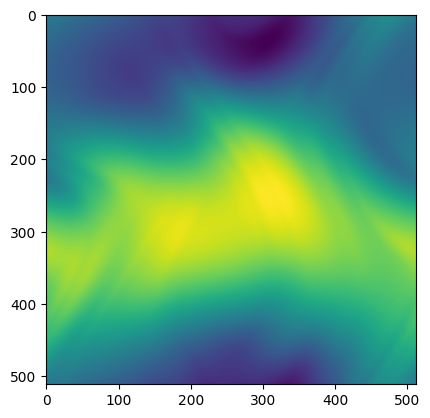

In [311]:
plt.imshow(data[400,:,:,0])

In [278]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))
    
class Interp2dAcrossTimesteps:
    def __init__(self, data, x_coords, y_coords, kind='linear'):
        # self.data = data
        # self.x_coords = x_coords
        # self.y_coords = y_coords
        self.interp = [RegularGridInterpolator((x_coords,y_coords),  np.transpose(data[i,:,:,:],(1,0,2)), method=kind, bounds_error=False, fill_value=None) for i in range(data.shape[0])]

    def __call__(self, points, timesteps):
        return np.stack([self.interp[timestep](points) for timestep in timesteps],0)
    
class Interp2Dslice:
    def __init__(self, interp2dAT, dT_arr):
        self.interp2dAT = interp2dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr*2)

    
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])

class Interp1dAcrossTimesteps:
    def __init__(self, dataB, distance, kind='pchip'):
        if kind == 'pchip':
            self.interp = [Interp1DPchipPeriodic(distance, dataB[i]) for i in range(dataB.shape[0])]
        else:
            self.interp = [Interp1DPeriodic(distance, dataB[i],kind=kind) for i in range(dataB.shape[0])]

    def __call__(self, x, timesteps):
        return np.stack([self.interp[timestep](x) for timestep in timesteps],0)

# input: file_path,dT_arr
def loadData(file_path, dT_arr):
    data = read_am_file(file_path)

    NT = data.shape[0]
    NX = data.shape[1]
    NY = data.shape[2]
    Nv = data.shape[3]

    x = np.linspace(0, 1, NX)
    X,Y = np.meshgrid(x, x)

    # Comon for all timesteps
    nodes = np.stack([X.flatten(),Y.flatten()],-1)
    idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
    elementsBoundaryNodesOnly = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)
    areaElementsBoundaryNodesOnly = np.array([0.5,0.5])
    isInDomain = IsInDomain([nodes[[idxCorner[0],idxCorner[1],idxCorner[3],idxCorner[2],idxCorner[0]]]])
    idxCurves = [np.concatenate([np.arange(NX),np.arange(2*NX-1,NY*NX,NX),np.arange(NY*NX-2,(NY-1)*NX-1,-1),np.arange((NY-2)*NX,-1,-NX)])]
    distance = [np.arange(0,idxCurve.shape[0])*1.0/(NX-1) for idxCurve in idxCurves]
    lengthCurves = [4]
    nodesCurves = [nodes[idxCurve] for idxCurve in idxCurves]
    idxCurveCorner = np.array([0,0,0,0],dtype=int)
    distanceCornerCurve = np.array([0,1,3,2],dtype=int)
    distance2boundary = np.min(np.stack([np.abs(X),np.abs(X-1),np.abs(Y),np.abs(Y-1)],-1),-1)
    interpD2B = RegularGridInterpolator((x,x),distance2boundary, method='linear', bounds_error=False, fill_value=None)
    interpBC = [Interp1DPeriodic(distance[0],nodesCurves[0],kind='linear')]
    normalCurves = [np.zeros((idxCurves[0].shape[0],2))]
    normalCurves[0][nodesCurves[0][:,0]==0,0] = -1
    normalCurves[0][nodesCurves[0][:,0]==1,0] = 1
    normalCurves[0][nodesCurves[0][:,1]==0,1] = -1
    normalCurves[0][nodesCurves[0][:,1]==1,1] = 1
    normalCurves[0] = normalCurves[0]/np.sqrt(np.sum(normalCurves[0]**2,1,keepdims=True))
    interpBN = [Interp1DPeriodic(distance[0],normalCurves[0],kind='linear')]

    interp2dAcrossTimesteps = Interp2dAcrossTimesteps(data, x, x)
    dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
    interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

    data_processed = []
    for i in range(-dT_arr[0],NT-dT_arr[-1]):
        interpSE = lambda points, idxs = dT_arr+i: interp2dAcrossTimesteps(points, idxs)
        interpSD = lambda points, idxs = [i]: interp2dAcrossTimesteps(points, idxs)
        interpBS = [lambda x,idxs=dT_arr+i: interp1dAcrossTimesteps[0](x, idxs)]
        data_processed.append(
            {'nodes': nodes,'elementsBoundaryNodesOnly': elementsBoundaryNodesOnly,'areaElementsBoundaryNodesOnly': areaElementsBoundaryNodesOnly,
            'isInDomain': isInDomain,'interpSE': interpSE,'interpSD': interpSD,'interpD2B': interpD2B,'nodesCurves': nodesCurves,
            'lengthCurves': lengthCurves,'interpBC': interpBC,'interpBS': interpBS,'interpBN': interpBN,
            'distanceCornerCurve': distanceCornerCurve, 'idxCurveCorner': idxCurveCorner, 'dT': i}
        )

    return data_processed

file_path = r'TrainingData/TurbulentFlowData/2400.am'
data_processed = loadData(file_path, np.arange(-50,0,5))

In [279]:
d = np.linspace(0,4,1001)[:-1]
idxT = 100
nodesB_test = data_processed[idxT]['interpBC'][0](d)
# valB_test = interp1dAcrossTimesteps[0](d, [100])
valB_test = data_processed[idxT]['interpBS'][0](d)
iT = data_processed[idxT]['dT']

X,Y = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
points = np.stack([X.flatten(),Y.flatten()],-1)
val_test = data_processed[idxT]['interpSE'](points)

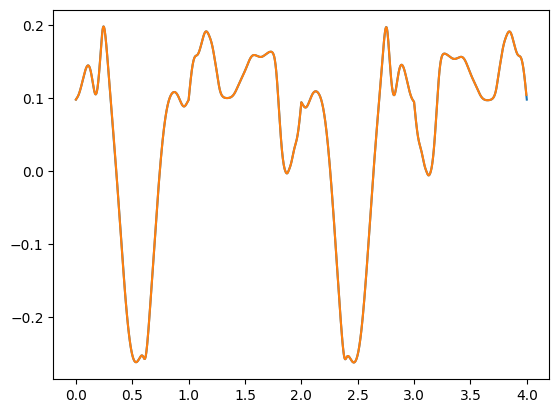

In [282]:
plt.plot(distance[0],dataB[0][120,:,1])
plt.plot(d,valB_test[4,:,1])

(50, 10000, 2)

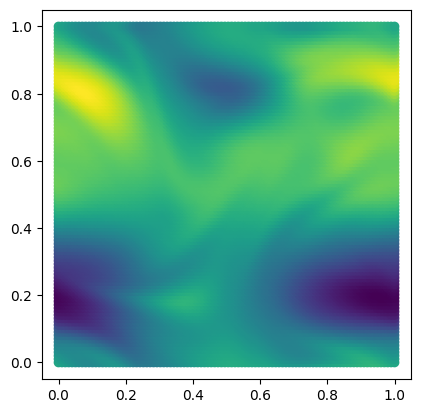

In [283]:
plt.scatter(points[:,0],points[:,1],c=val_test[4,:,0])
plt.gca().set_aspect('equal', adjustable='box')

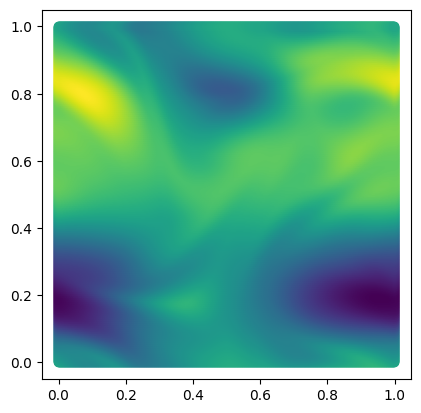

In [284]:
plt.scatter(nodes[:,0],nodes[:,1],c=data[120, :, :, 0].flatten())
plt.gca().set_aspect('equal', adjustable='box')

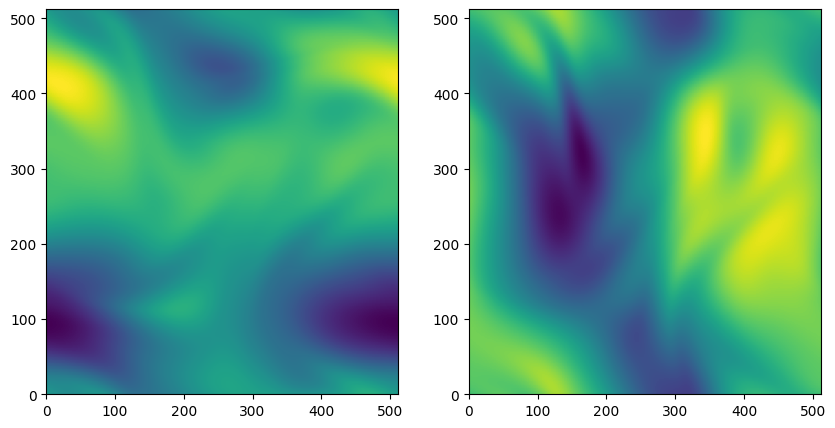

In [241]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.pcolormesh(data[100,:,:,0])
plt.subplot(1,2,2)
plt.pcolormesh(data[100,:,:,1])
plt.show()

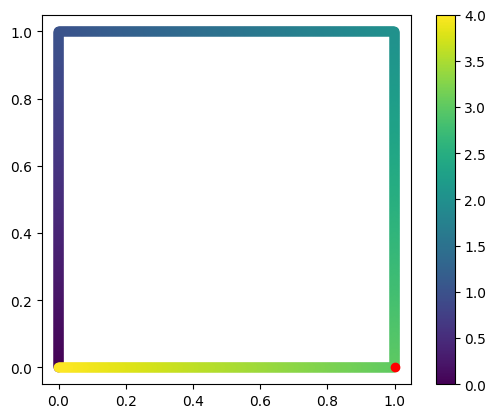

In [81]:
nodesB = nodesCurves[0]
plt.scatter(nodesB[:,0],nodesB[:,1],c = distance[0])
plt.colorbar()
plt.gca().set_aspect('equal')
plt.scatter([1],[0],c='r')

In [280]:
idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
elements = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)